# Image Deraining

The proximal algorithms were typically used and more suitable to solve inverse problems with known forward models. Here, we explore the proximal algorithms for problems where the forward models are unknown and learned alongside the optimization.

We consider here image deraining, i.e., the removal of rain streaks from an image, as an example for this class of problems. This problem is severely ill-posed as the assignment to a rain layer and latent background layer is unknown a-prior. 

As such, researchers typically employ end-to-end black-box neural networks that learn to predict latent clean images from paired datasets. 
Being able to compile differentiable solvers, ∇-Prox facilitates learnable forward operators by making `LinOp` learnable for joint optimization.

In [ ]:
# uncomment the following line to install dprox if your are in online google colab notebook
# !pip install dprox

In [1]:
import torch

from dprox import *
from dprox.utils import *

Here is an example of original image and rainy image taken from [Rain100L](). 

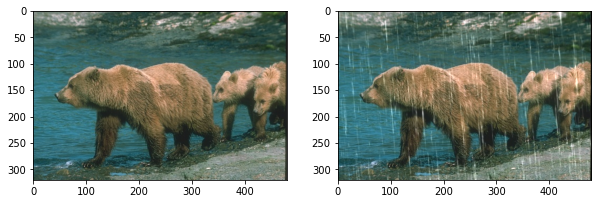

In [2]:
b = imread('sample_data/derain_input.png')
gt = imread('sample_data/derain_target.png')
imshow(gt, b)

To solve the problem, we could unroll the iterations of proximal gradient descent algorithm and learn the forward model, i.e. degradation operator `LearnalbeDegOp`, and unrolled image prior `unrolled_prior`.

35.91962211701706


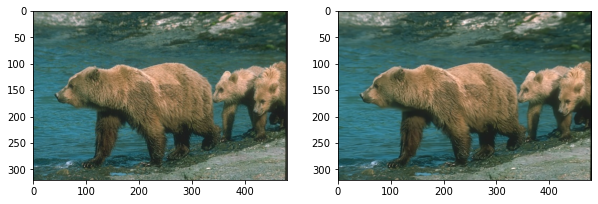

In [3]:
from dprox.utils.examples.derain import LearnableDegOp

# custom linop
A = LearnableDegOp().cuda()
def forward_fn(input, step): return A.forward(input, step)
def adjoint_fn(input, step): return A.adjoint(input, step)
raining = LinOpFactory(forward_fn, adjoint_fn)

# build solver
x = Variable()
data_term = sum_squares(raining(x), b)
reg_term = unrolled_prior(x)
obj = data_term + reg_term
solver = compile(obj, method='pgd')

# load parameters
ckpt = torch.load(get_path('checkpoints/derain_pdg.pth'))
A.load_state_dict(ckpt['linop'])
reg_term.load_state_dict(ckpt['prior'])
rhos = ckpt['rhos']

out = solver.solve(x0=b, rhos=rhos, max_iter=7)
out = to_ndarray(out, debatch=True) + b
print(psnr(out, gt))  # 35.92
imshow(gt, out)
